In [1]:
# ==========================================================   EDA   ===========================================================

In [2]:
# ========================================
# 1. Imports
# ========================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, mean_absolute_error

import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)


# --------------------------------------------
# משתנה גלובלי לשמירת ה‐batch_size שייבחר ע"י החיפוש
# --------------------------------------------
BEST_BATCH_SIZE = None


C:\Users\Gleb\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ========================================
# 2. Load Dataset and define 4 columns
# ========================================

DATA_PATH = r"C:\Users\Gleb\Desktop\N.L.P\CHATGPT_DATASET.csv"
df = pd.read_csv(DATA_PATH, encoding='cp1252', engine='python')
df.dropna(subset=["review"], inplace=True)

labels = ["difficulty","interest","usefulness","teaching_quality"]
assert all(c in df.columns for c in labels)

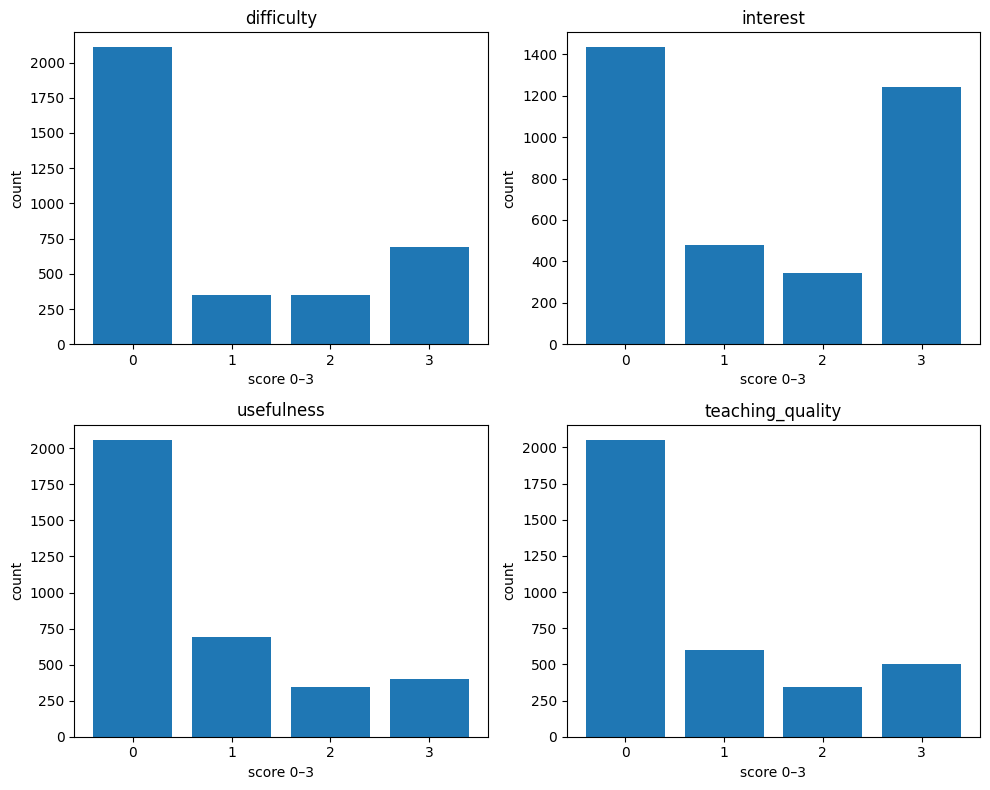

In [4]:
# ========================================
# 3.1 EDA: Scores per Label Distribution
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()
for ax, lab in zip(axes, labels):
    counts = df[lab].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(lab)
    ax.set_xlabel("score 0–3")
    ax.set_ylabel("count")
plt.tight_layout()
plt.show()

Total responses: 3500
Responses with no zeros: 201 (5.7%)
Responses with exactly 1 zero: 502 (14.3%)
Responses with exactly 2 zeros: 1237 (35.3%)
Responses with exactly 3 zeros: 1560 (44.6%)
Responses with at least one zero label: 3299 (94.3%)


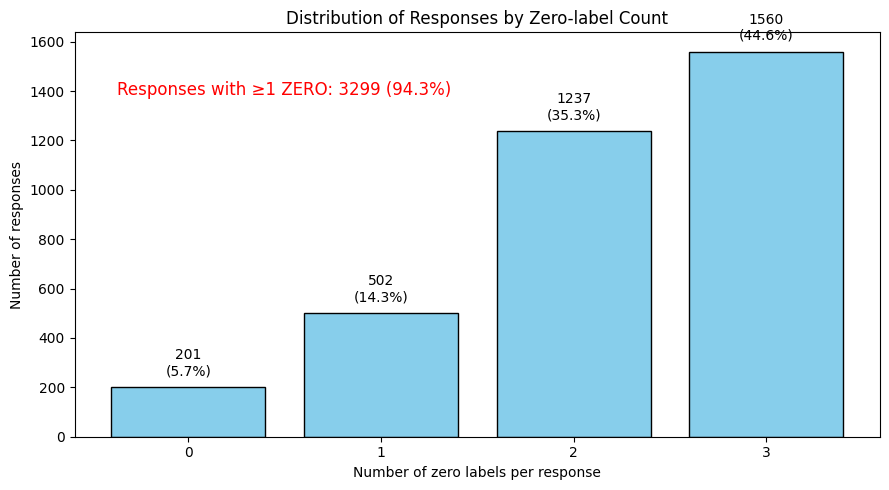

In [5]:
# =================================
# 3.2 EDA:Count zeros per response 
# =================================


import pandas as pd
import matplotlib.pyplot as plt

labels = ['difficulty', 'interest', 'usefulness', 'teaching_quality']

# 1. Compute how many zeros each response has
zeros_per_response = df[labels].eq(0).sum(axis=1)

# 2. Frequencies for 0, 1, 2, and 3 zeros
counts = zeros_per_response.value_counts().sort_index()
# Ensure we have all four categories (0 through 3)
freq = counts.reindex([0, 1, 2, 3], fill_value=0)

# 3. Count of responses with at least one zero
at_least_one_count = (zeros_per_response >= 1).sum()
total_responses = len(df)
at_least_one_pct = at_least_one_count / total_responses * 100

# Print summary
print(f"Total responses: {total_responses}")
print(f"Responses with no zeros: {freq.loc[0]} ({freq.loc[0] / total_responses * 100:.1f}%)")
print(f"Responses with exactly 1 zero: {freq.loc[1]} ({freq.loc[1] / total_responses * 100:.1f}%)")
print(f"Responses with exactly 2 zeros: {freq.loc[2]} ({freq.loc[2] / total_responses * 100:.1f}%)")
print(f"Responses with exactly 3 zeros: {freq.loc[3]} ({freq.loc[3] / total_responses * 100:.1f}%)")
print(f"Responses with at least one zero label: {at_least_one_count} ({at_least_one_pct:.1f}%)")

# 4. Plot bar chart with counts and percentages (including zero category)
percentages = freq / total_responses * 100

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(freq.index.astype(str), freq.values, color='skyblue', edgecolor='black')

# Annotate each bar with count and percentage
for bar, count, pct in zip(bars, freq.values, percentages.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + total_responses * 0.01,  # small offset above bar
        f"{count}\n({pct:.1f}%)",
        ha='center', va='bottom', fontsize=10
    )

# Annotate total with at least one zero on the plot
ax.text(
    0.5, max(freq.values) * 0.9,
    f"Responses with ≥1 ZERO: {at_least_one_count} ({at_least_one_pct:.1f}%)",
    ha='center', va='center',
    fontsize=12, color='red'
)

ax.set_xlabel("Number of zero labels per response")
ax.set_ylabel("Number of responses")
ax.set_title("Distribution of Responses by Zero-label Count")
plt.tight_layout()
plt.show()


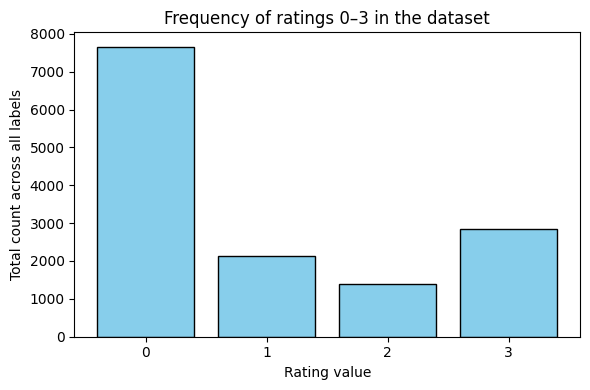

In [6]:
# ===================================
# 3.3 EDA: Frequency of rating value
# ===================================

# Define label columns
labels = ['difficulty', 'interest', 'usefulness', 'teaching_quality']

# Aggregate all label values into one series
all_scores = df[labels].values.flatten()

# Compute counts for each rating 0–3
score_counts = pd.Series(all_scores).value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(score_counts.index.astype(str), score_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Rating value")
plt.ylabel("Total count across all labels")
plt.title("Frequency of ratings 0–3 in the dataset")
plt.tight_layout()
plt.show()
plt.show()

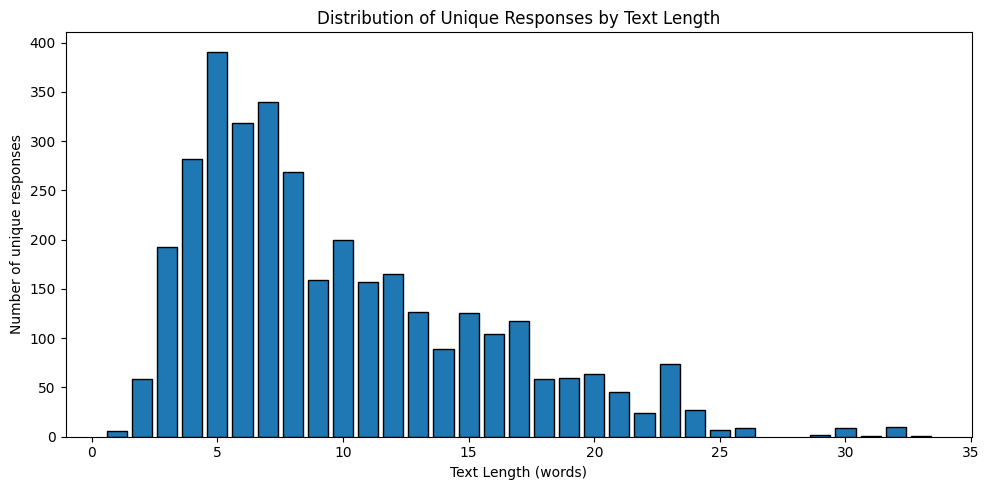

Median response length: 8 words
Total unique responses with 5 words or fewer: 931


In [7]:
# ================================================
# 3.4 EDA: Distribution of reponses by text length
# ================================================


import pandas as pd
import matplotlib.pyplot as plt

# Load and clean data
df = pd.read_csv(r"C:\Users\Gleb\Desktop\N.L.P\CHATGPT_DATASET.csv", encoding='cp1252', engine='python')
df.dropna(subset=['review'], inplace=True)
df.drop_duplicates(subset=['review'], inplace=True)

# Compute word count per review
df['length_words'] = df['review'].str.split().str.len()

# Plot histogram with original size (10×5)
plt.figure(figsize=(10, 5))
length_counts = df['length_words'].value_counts().sort_index()
plt.bar(length_counts.index, length_counts.values, edgecolor='black')
plt.xlabel("Text Length (words)")
plt.ylabel("Number of unique responses")
plt.title("Distribution of Unique Responses by Text Length")
plt.tight_layout()
plt.show()

# Calculate median length
median_length = df['length_words'].median()
print(f"Median response length: {median_length:.0f} words")

# Count how many unique responses have 1–5 words and print
counts_1_to_5 = length_counts.reindex(range(1, 6), fill_value=0)
total_up_to_5 = counts_1_to_5.sum()
print(f"Total unique responses with 5 words or fewer: {total_up_to_5}")


In [8]:
# ================================================
# 3.5 EDA: Num of Labeling scoring combinations
# ================================================


import pandas as pd

def count_label_combinations(file_path):
    """
    Loads a CSV file from the given path, computes all unique combinations of the four label columns,
    and prints a neatly formatted table showing each label (as עמודה נפרדת) ואת העמודה count. 
    Finally, prints the total number of unique combinations.
    
    Parameters:
    - file_path: string path to the CSV file.
    
    Returns:
    A dictionary containing:
      • 'counts_dataframe': DataFrame with columns ['difficulty', 'interest', 'usefulness', 
        'teaching_quality', 'count'] sorted by count descending.
      • 'unique_combinations': integer number of unique combinations found.
    """
    # 1. Load the DataFrame from CSV (CP1252 encoding assumed)
    df = pd.read_csv(file_path, encoding='cp1252', engine='python')

    # 2. Ensure required columns exist
    required_cols = ['difficulty', 'interest', 'usefulness', 'teaching_quality']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in the file.")

    # 3. (If there is a 'review' column) drop rows with missing review text
    if 'review' in df.columns:
        df = df.dropna(subset=['review'], how='any')

    # 4. Group by the four label columns and count occurrences
    combo_counts = (
        df
        .groupby(required_cols)
        .size()
        .reset_index(name='count')
    )

    # 5. צור DataFrame מסודר עם העמודות הבאות: 'difficulty', 'interest', 'usefulness',
    #    'teaching_quality', 'count', ממויין לפי 'count' בסדר יורד
    result_table = combo_counts[required_cols + ['count']].sort_values(by='count', ascending=False)

    # 6. Print a nicely formatted table to the console
    print("\nCombination Counts (sorted by count):\n")
    print(result_table.to_string(index=False))

    # 7. Print the total number of unique combinations
    num_unique_combinations = combo_counts.shape[0]
    print(f"\nNumber of unique combinations: {num_unique_combinations}\n")

    return {
        'counts_dataframe': result_table,
        'unique_combinations': num_unique_combinations
    }

# Example usage (replace with your actual path):
result = count_label_combinations(r"C:\Users\Gleb\Desktop\N.L.P\CHATGPT_DATASET.csv")



Combination Counts (sorted by count):

 difficulty  interest  usefulness  teaching_quality  count
          0         3           1                 0    300
          3         1           1                 1    201
          0         3           2                 0    200
          0         3           0                 1    200
          2         2           0                 2    200
          1         3           0                 3    200
          2         0           0                 0    150
          0         0           3                 3    150
          0         0           0                 3    150
          0         0           3                 0    150
          1         0           0                 0    148
          0         0           0                 2    147
          0         0           2                 0    146
          0         3           0                 0    143
          0         2           0                 0    142
          3     